# **EJERCICIO PARTE PRÁCTICA SERIES TEMPORALES**
---
---
En este ejercicio los alumnos deben demostrar que son capaces de utilizar el programa Python de forma adecuada para trabajar con series temporales.
Para ello se les facilitan unos datos sobre una serie temporal, a su vez se permite que usen apuntes, los códigos compartidos durante las sesiones, así como ayuda complementaria que puedan encontrar en internet. También esta permitido trabajar en grupos de hasta 3 personas.

Las tareas que deben realizar son:
1. Determinar si es una serie estacionaria o no, utilizando diferentes procedimientos. En este punto es necesario realizar análisis gráficos y diferentes test.

2. Determinar si es una serie estacional y en su caso cual es la frecuencia con la que se da la estacionalidad.

3. Determinar cuál es modelo óptimo para estimar. Para ello se puede utilizar el autoarima u otro tipo de análisis.

4. Comprobar que el modelo estimado es correcto. Para este punto es necesario tanto analizar las predicciones como los residuos


In [130]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima
import warnings

# Ignorar warnings
warnings.filterwarnings('ignore')

In [67]:
#os.chdir(r"Python/Teoria/SeriesTemporales1_Creditos.py")

In [68]:
# Cargamos los datos
datos = pd.read_csv("DatosEjercicio.csv")

In [69]:
datos.shape

(476, 2)

In [70]:
# Información inicial del dataset
print("--- Información del Dataset ---\n")
datos.info()

--- Información del Dataset ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   476 non-null    object 
 1   Value   476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [71]:
datos.head()

,Month,Value
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


---

#### Pasamos la fecha a formato fecha

In [72]:
# Convertir la columna 'Month' al formato datetime
datos["Month"] = pd.to_datetime(datos["Month"], format="%Y-%m")

In [73]:
# # Si hay valores inesperados en la columna que no coincidan con este formato, podrías usar el parámetro errors='coerce' para manejarlos
# datos["Month"] = pd.to_datetime(datos["Month"], format="%Y-%m", errors='coerce')

In [74]:
# Dataset con 
print("--- Información del Dataset ---\n")
datos.info()

--- Información del Dataset ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   476 non-null    datetime64[ns]
 1   Value   476 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


In [75]:
# Pasamos la fecha al indice
datos.index = datos["Month"]

In [76]:
# Eliminamos la columna Month
del (datos["Month"])

In [77]:
datos.head()

,Value
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


---
## **Paso 1: Determinar si la serie es estacionaria**
---
---
#### La estacionariedad se evalúa mediante:
1. Análisis gráfico: Observar la gráfica para identificar tendencias o varianzas crecientes.
2. Pruebas estadísticas: Realizar el test ADF (Augmented Dickey-Fuller), KPSS y otros contrastes.

#### **1.1 — Requisitos para una serie estacionaria**
- Media constante
- Varianza constante
- Autocorrelación constante
##### Este análisis se realiza gráficamente y con pruebas estadísticas.

#### **1.2 _ Análisis gráfico inicial**

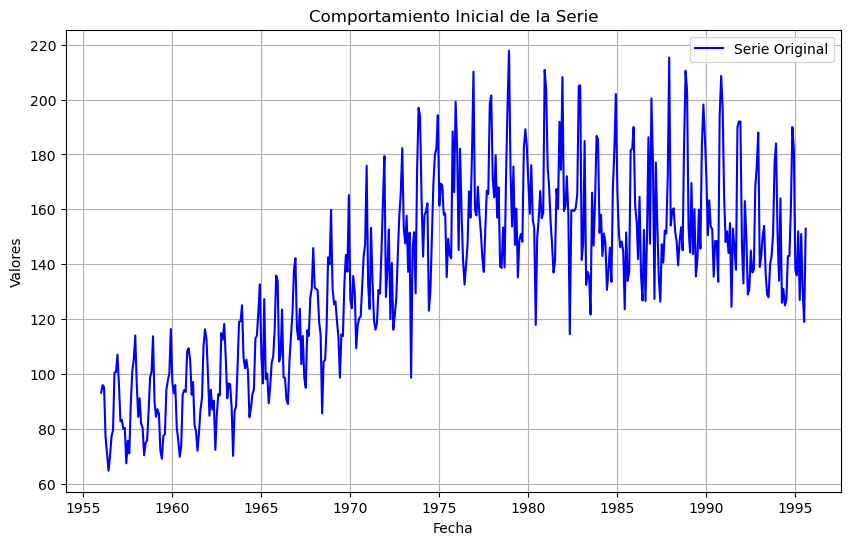

In [78]:
# Observar si hay tendencias o patrones de crecimiento/decadencia en la media y varianza
plt.figure(figsize=(10, 6))
plt.plot(datos, label="Serie Original", color="blue")
plt.title("Comportamiento Inicial de la Serie")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

#### **1.3 _ Cálculo del número de diferencias necesarias (ndiffs)**

In [79]:
# Usamos `ndiffs` de pmdarima para verificar el número de diferencias necesarias
# Respecto a la observacion anterior -> Hay que fijarse 
# si nos sale 0 
# si nos sale 1 no
num_diffs = pmdarima.arima.ndiffs(datos)
print(f"Número de diferencias necesarias para estacionarizar: {num_diffs}")

Número de diferencias necesarias para estacionarizar: 1


In [80]:
# Estacionalmente con estacionalidad anual.
pmdarima.arima.nsdiffs(datos, m = 12)

0

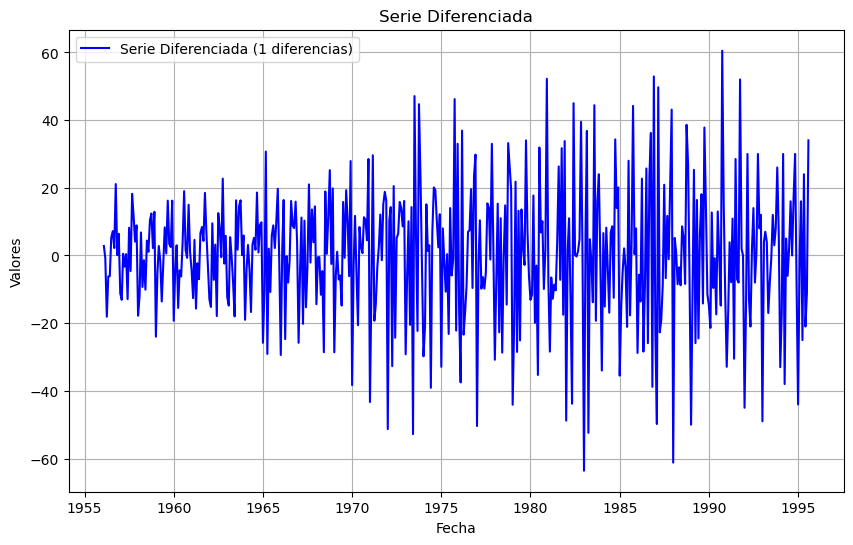

In [81]:
# Si es necesario diferenciar, aplicamos las diferencias
if num_diffs > 0:
    datos_dif = pd.DataFrame(pmdarima.utils.diff(datos, lag=1, differences=num_diffs))
    datos_dif.index = datos.index[num_diffs:]  # Ajustar índice tras diferenciar
    plt.figure(figsize=(10, 6))
    plt.plot(datos_dif, label=f"Serie Diferenciada ({num_diffs} diferencias)", color="blue")
    plt.title("Serie Diferenciada")
    plt.xlabel("Fecha")
    plt.ylabel("Valores")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    datos_dif = datos.copy()
    print("La serie ya es estacionaria, no se realizaron diferencias.")

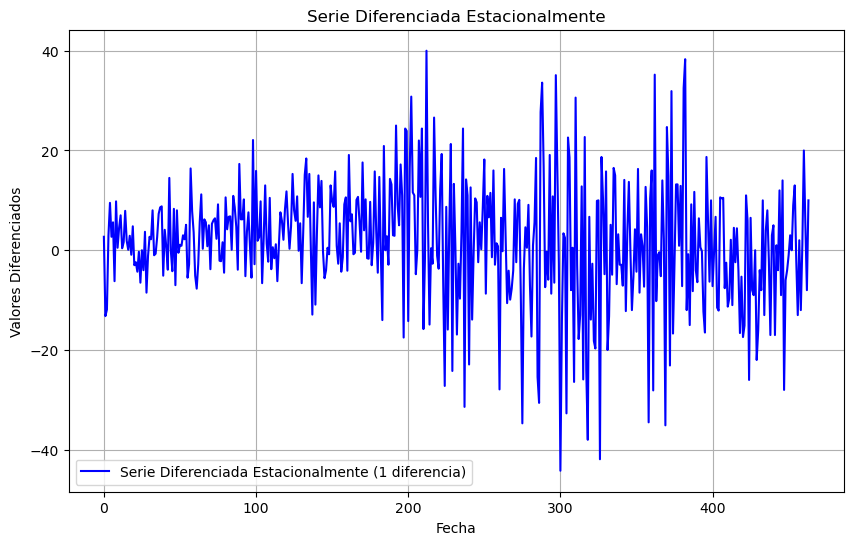

In [82]:
# Pasamos a probar la vía estacional (diferencias estacionales)
datosdiff_Est = pmdarima.utils.diff(datos, lag=12, differences=1)

# Graficar la serie diferenciada estacionalmente
plt.figure(figsize=(10, 6))
plt.plot(datosdiff_Est, label="Serie Diferenciada Estacionalmente (1 diferencia)", color="blue")
plt.title("Serie Diferenciada Estacionalmente")
plt.xlabel("Fecha")
plt.ylabel("Valores Diferenciados")
plt.legend()
plt.grid(True)
plt.show()

#### **1.4 _ Test ADF (Augmented Dickey-Fuller)**

In [83]:
# H0: La serie no es estacionaria (raíz unitaria)
adf_test = adfuller(datos["Value"])
print('--- Resultados del Test ADF ---')
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
if adf_test[1] < 0.05:
    print("Rechazamos H0: La serie es estacionaria")
else:
    print("No podemos rechazar H0: La serie NO es estacionaria")

--- Resultados del Test ADF ---
ADF Statistic: -2.2826614187875727
p-value: 0.17762099829132655
No podemos rechazar H0: La serie NO es estacionaria


#### **1.5 _ Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

In [84]:
# H0: La serie es estacionaria
kpss_test = kpss(datos["Value"], regression='c')
print('--- Resultados del Test KPSS ---')
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
if kpss_test[1] < 0.05:
    print("Rechazamos H0: La serie NO es estacionaria")
else:
    print("No podemos rechazar H0: La serie es estacionaria")

--- Resultados del Test KPSS ---
KPSS Statistic: 2.9654643479835916
p-value: 0.01
Rechazamos H0: La serie NO es estacionaria


#### **1.6 _ Gráfica de comparación (Serie Original vs Serie Diferenciada)**

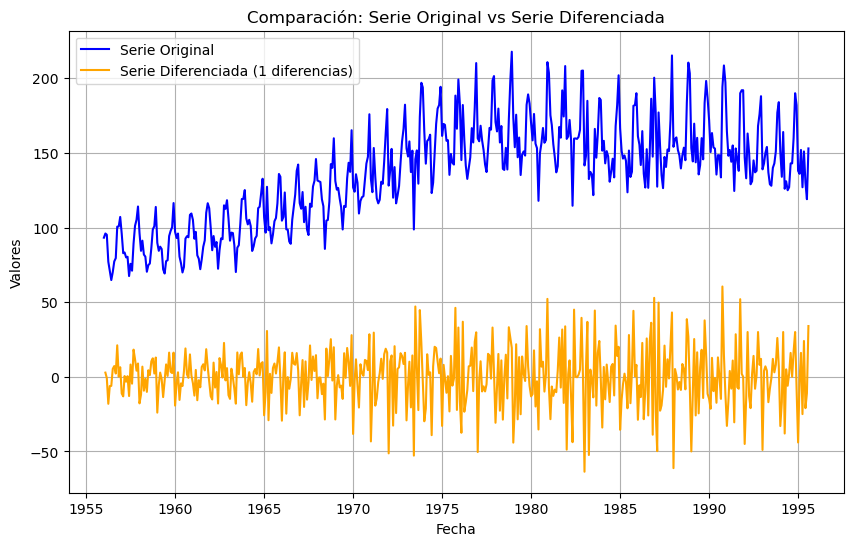

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(datos, label="Serie Original", color="blue")
if num_diffs > 0:
    plt.plot(datos_dif, label=f"Serie Diferenciada ({num_diffs} diferencias)", color="orange")
plt.title("Comparación: Serie Original vs Serie Diferenciada")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

#### **1.7 _ Resumen de resultados**

In [86]:
# En este punto, basándonos en los análisis gráficos, número de diferencias calculadas, y los tests ADF y KPSS, determinaremos si la serie es estacionaria.
if adf_test[1] < 0.05 and kpss_test[1] >= 0.05:
    print("Conclusión: La serie es estacionaria.")
elif adf_test[1] >= 0.05 and kpss_test[1] < 0.05:
    print("Conclusión: La serie NO es estacionaria.")
else:
    print("Conclusión: Resultados mixtos. Podría requerir más análisis o ajustes.")

Conclusión: La serie NO es estacionaria.


#### **1.8 _ Aplicar logaritmos**

In [87]:
# Aplicar logaritmos a la serie
datos_log = np.log(datos)

In [88]:
datos_log.head()

,Value
Month,
1956-01-01,4.534748
1956-02-01,4.564348
1956-03-01,4.555980
1956-04-01,4.345103
1956-05-01,4.261270


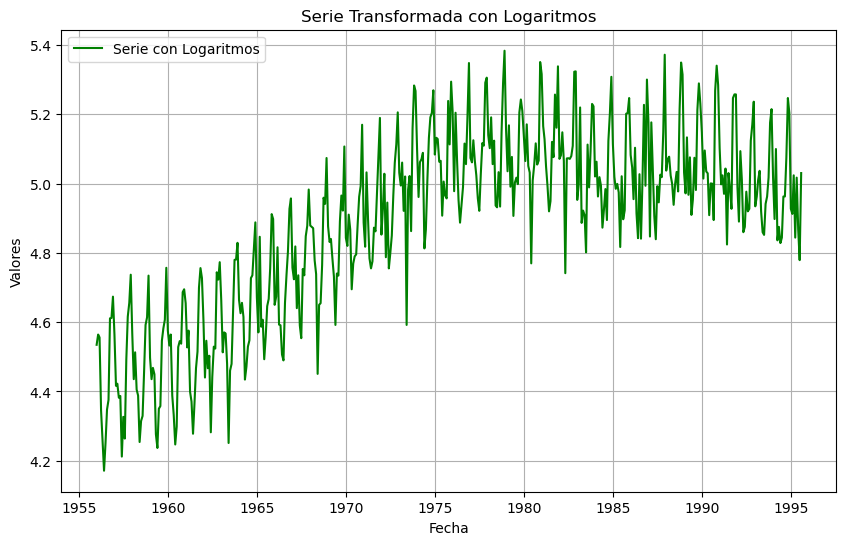

In [89]:
# Graficar la serie transformada con logaritmos
plt.figure(figsize=(10, 6))
plt.plot(datos_log, label="Serie con Logaritmos", color="green")
plt.title("Serie Transformada con Logaritmos")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
# Aplicar diferencias a la serie con logaritmos
datos_log_dif = pd.DataFrame(pmdarima.utils.diff(datos_log, lag=1, differences=1))
datos_log_dif.index = datos.index[1:]  # Ajustar el índice tras diferenciar

In [91]:
datos_log_dif.head()

,0
Month,
1956-02-01,0.029600
1956-03-01,-0.008368
1956-04-01,-0.210877
1956-05-01,-0.083833
1956-06-01,-0.089965


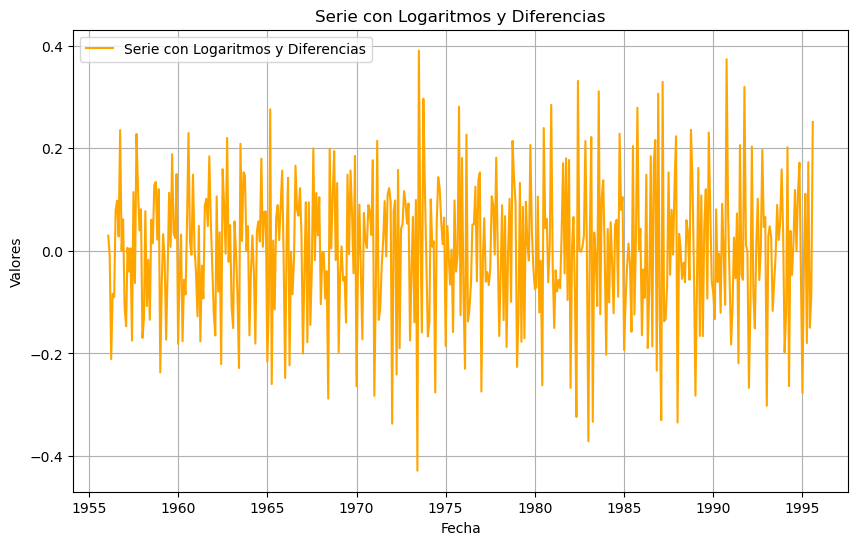

In [92]:
# Graficar la serie transformada con logaritmos y diferencias
plt.figure(figsize=(10, 6))
plt.plot(datos_log_dif, label="Serie con Logaritmos y Diferencias", color="orange")
plt.title("Serie con Logaritmos y Diferencias")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# Test ADF para verificar estacionariedad
adf_test_log_dif = adfuller(datos_log_dif.iloc[:, 0])
print('--- Resultados del Test ADF (Logaritmos y Diferencias) ---')
print(f"ADF Statistic: {adf_test_log_dif[0]}")
print(f"p-value: {adf_test_log_dif[1]}")
if adf_test_log_dif[1] < 0.05:
    print("Rechazamos H0: La serie es estacionaria")
else:
    print("No podemos rechazar H0: La serie NO es estacionaria")

--- Resultados del Test ADF (Logaritmos y Diferencias) ---
ADF Statistic: -4.869645674436221
p-value: 3.994274317729681e-05
Rechazamos H0: La serie es estacionaria


In [94]:
# Test KPSS para verificar estacionariedad
kpss_test_log_dif = kpss(datos_log_dif.iloc[:, 0], regression='c')
print('--- Resultados del Test KPSS (Logaritmos y Diferencias) ---')
print(f"KPSS Statistic: {kpss_test_log_dif[0]}")
print(f"p-value: {kpss_test_log_dif[1]}")
if kpss_test_log_dif[1] < 0.05:
    print("Rechazamos H0: La serie NO es estacionaria")
else:
    print("No podemos rechazar H0: La serie es estacionaria")

--- Resultados del Test KPSS (Logaritmos y Diferencias) ---
KPSS Statistic: 0.009147793586345224
p-value: 0.1
No podemos rechazar H0: La serie es estacionaria


---
## **Paso 2: Determinar si la serie es estacional** 
---
---

#### La estacionalidad se evalúa mediante:

1. Análisis gráfico: Observamos patrones repetitivos.

2. Pruebas estadísticas: Identificar si la estacionalidad se da a una frecuencia específica.

#### **2.1 _ Gráfica de la serie original**

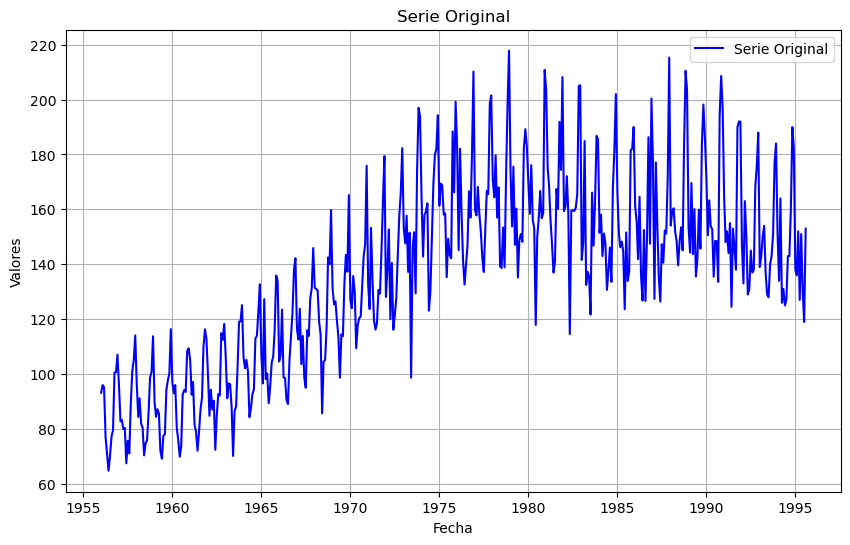

In [95]:
plt.figure(figsize=(10, 6))
plt.plot(datos, label="Serie Original", color="blue")
plt.title("Serie Original")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)
plt.show()

#### **2.2 _ Prueba de estacionalidad: Número de diferencias estacionales sugeridas**

In [96]:
# Test para determinar la estacionalidad
# Usamos la función `nsdiffs` con frecuencia m=12 (anual)
estacionalidad = pmdarima.arima.nsdiffs(datos, m=12)
print(f"Número de diferencias estacionales sugeridas (m=12): {estacionalidad}")

Número de diferencias estacionales sugeridas (m=12): 0


In [97]:
# Si la frecuencia no está clara, intentamos con otras periodicidades (e.g., m=4 para trimestral)
otras_estacionalidades = pmdarima.arima.nsdiffs(datos, m=4)
print(f"Número de diferencias estacionales sugeridas (m=4, trimestral): {otras_estacionalidades}")

Número de diferencias estacionales sugeridas (m=4, trimestral): 0


#### **2.3 _ Análisis gráfico - ACF y PACF de la serie original**

<Figure size 1000x600 with 0 Axes>

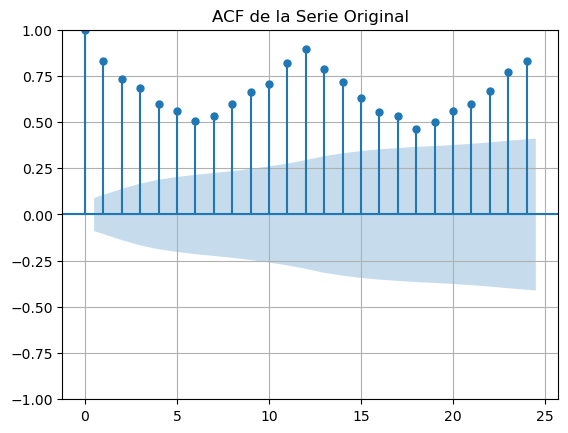

In [98]:
# Gráfico de ACF para observar patrones repetitivos (estacionalidad)
plt.figure(figsize=(10, 6))
plot_acf(datos, lags=24)  # ACF con 24 lags para observar ciclos repetitivos
plt.title("ACF de la Serie Original")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

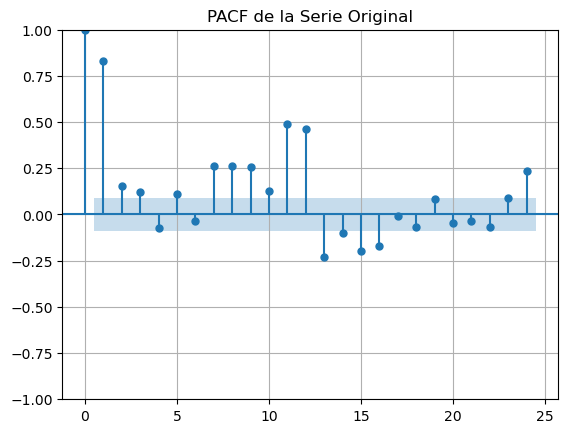

In [99]:
# Gráfico de PACF para observar patrones de correlación parcial
plt.figure(figsize=(10, 6))
plot_pacf(datos, lags=24)  # PACF con 24 lags
plt.title("PACF de la Serie Original")
plt.grid(True)
plt.show()

#### **2.4 _ Descomposición de la serie**

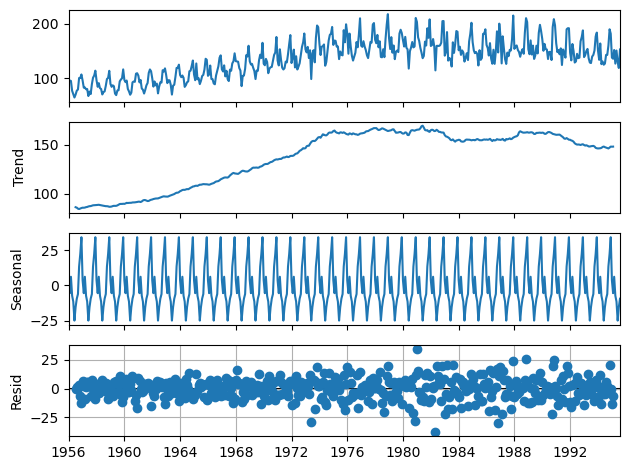

In [100]:
# Realizamos una descomposición aditiva para analizar la componente estacional
# Descomponer la serie en tendencia, estacionalidad y ruido
decomposition = seasonal_decompose(datos, model='additive', period=12)
decomposition.plot()
plt.grid(True)
plt.show()

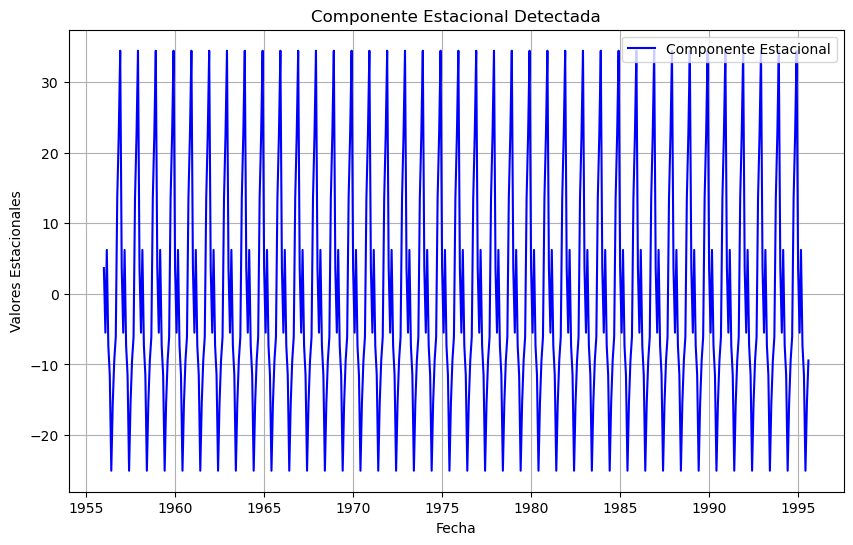

In [101]:
# Graficar la componente estacional
plt.figure(figsize=(10, 6))
plt.plot(decomposition.seasonal, label="Componente Estacional", color="blue")
plt.title("Componente Estacional Detectada")
plt.xlabel("Fecha")
plt.ylabel("Valores Estacionales")
plt.legend()
plt.grid(True)
plt.show()

#### **2.5 _. Análisis de periodicidad dominante**

In [102]:
# Analizar la periodicidad dominante en la componente estacional
componente_estacional = decomposition.seasonal
frecuencia_estacional = componente_estacional.index.to_series().diff().mode()[0]
print(f"Frecuencia estacional detectada: {frecuencia_estacional}")

Frecuencia estacional detectada: 31 days 00:00:00


#### **2.6 _ Resumen y conclusiones**

In [103]:
# Conclusión basada en los resultados obtenidos
if estacionalidad > 0:
    print("Conclusión: La serie presenta estacionalidad con una periodicidad de 12 pasos (anual).")
else:
    print("Conclusión: No se detecta estacionalidad significativa con una periodicidad de 12 pasos.")
    
if otras_estacionalidades > 0:
    print("Conclusión adicional: Se detecta posible estacionalidad con periodicidad trimestral (m=4).")
else:
    print("No se detecta estacionalidad significativa con periodicidad trimestral (m=4).")

Conclusión: No se detecta estacionalidad significativa con una periodicidad de 12 pasos.
No se detecta estacionalidad significativa con periodicidad trimestral (m=4).


### **Nuevas mejoras: Transformaciones para reducir autocorrelación**

#### **2.7 _ Aplicar diferenciación regular (d=1)**

In [104]:
# Diferenciar la serie para eliminar tendencias
datos_diff = pmdarima.utils.diff(datos, lag=1, differences=1)

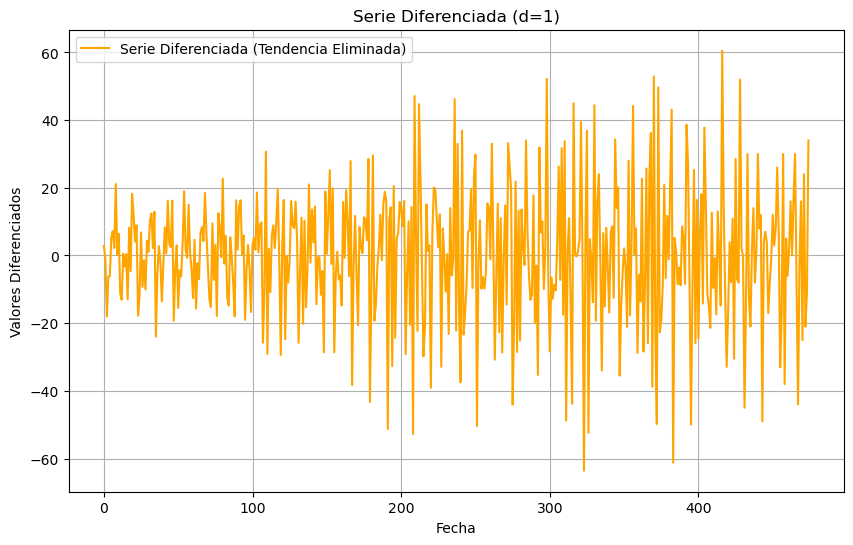

In [105]:
# Graficar la serie diferenciada
plt.figure(figsize=(10, 6))
plt.plot(datos_diff, label="Serie Diferenciada (Tendencia Eliminada)", color="orange")
plt.title("Serie Diferenciada (d=1)")
plt.xlabel("Fecha")
plt.ylabel("Valores Diferenciados")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

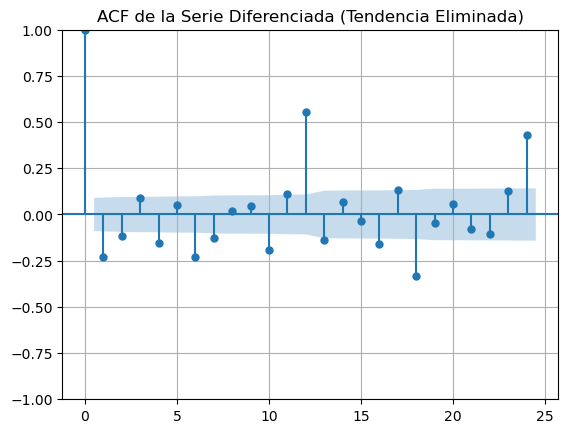

In [106]:
# Graficar ACF y PACF de la serie diferenciada
plt.figure(figsize=(10, 6))
plot_acf(datos_diff, lags=24)
plt.title("ACF de la Serie Diferenciada (Tendencia Eliminada)")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

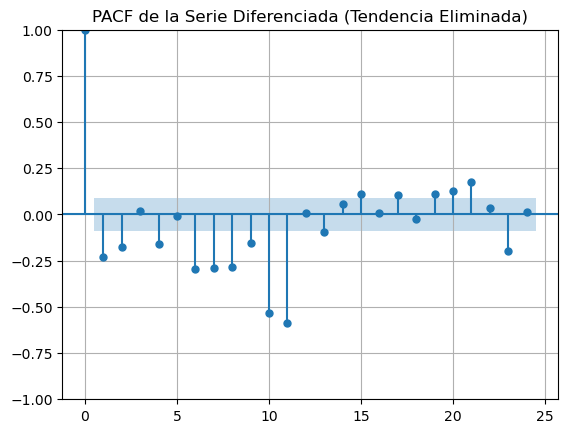

In [107]:
plt.figure(figsize=(10, 6))
plot_pacf(datos_diff, lags=24)
plt.title("PACF de la Serie Diferenciada (Tendencia Eliminada)")
plt.grid(True)
plt.show()

#### **2.8 _ Aplicar transformaciones logarítmicas**

In [108]:
# Aplicar logaritmos a la serie
datos_log = np.log(datos)

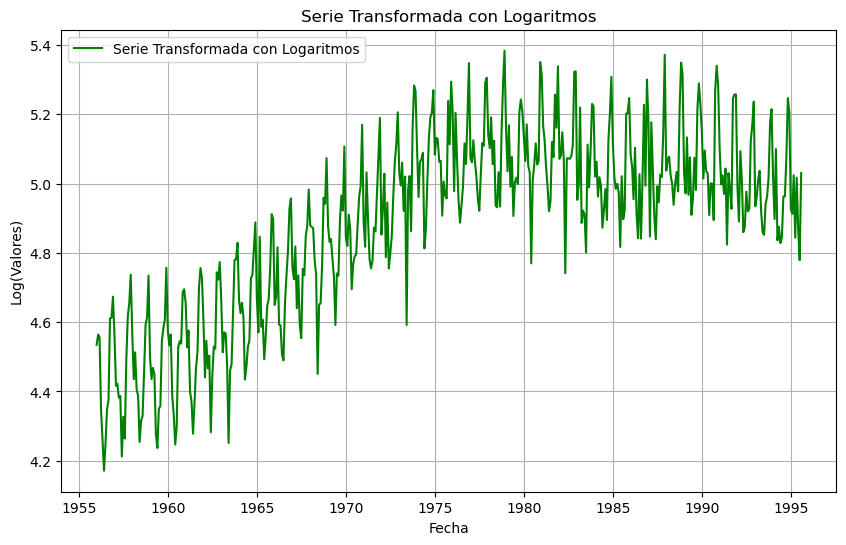

In [109]:
# Graficar la serie transformada con logaritmos
plt.figure(figsize=(10, 6))
plt.plot(datos_log, label="Serie Transformada con Logaritmos", color="green")
plt.title("Serie Transformada con Logaritmos")
plt.xlabel("Fecha")
plt.ylabel("Log(Valores)")
plt.legend()
plt.grid(True)
plt.show()

In [110]:
# Diferenciar la serie con logaritmos
datos_log_diff = pmdarima.utils.diff(datos_log, lag=1, differences=1)

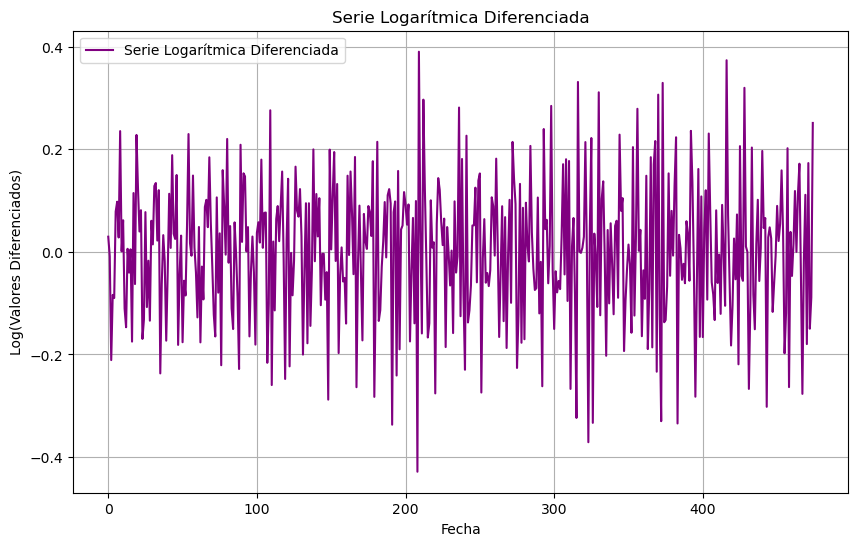

In [111]:
# Graficar la serie logarítmica diferenciada
plt.figure(figsize=(10, 6))
plt.plot(datos_log_diff, label="Serie Logarítmica Diferenciada", color="purple")
plt.title("Serie Logarítmica Diferenciada")
plt.xlabel("Fecha")
plt.ylabel("Log(Valores Diferenciados)")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

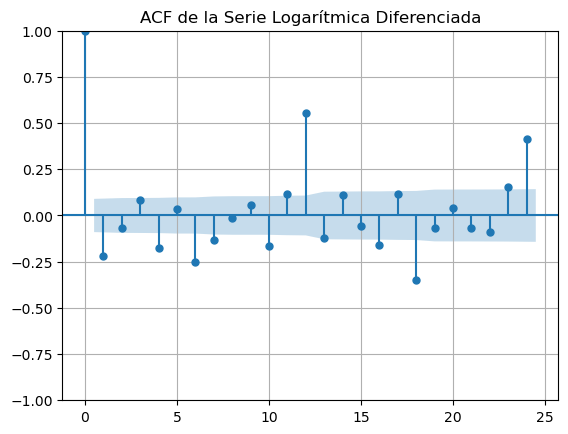

In [112]:
# Graficar ACF y PACF de la serie logarítmica diferenciada
plt.figure(figsize=(10, 6))
plot_acf(datos_log_diff, lags=24)
plt.title("ACF de la Serie Logarítmica Diferenciada")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

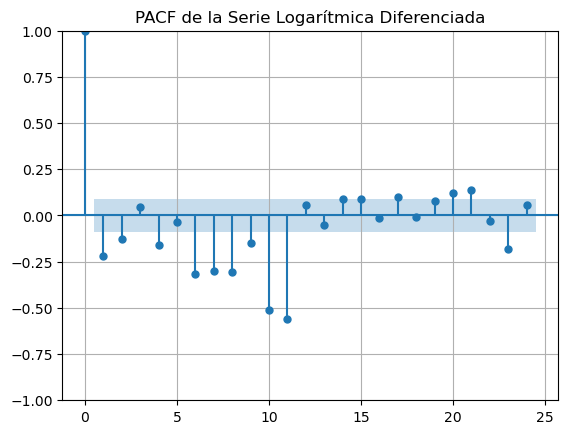

In [113]:
plt.figure(figsize=(10, 6))
plot_pacf(datos_log_diff, lags=24)
plt.title("PACF de la Serie Logarítmica Diferenciada")
plt.grid(True)
plt.show()

#### **2.9 _ Probar diferenciación estacional manualmente**

In [114]:
# Diferenciación estacional con lag=12
datos_seasonal_diff = pmdarima.utils.diff(datos, lag=12, differences=1)

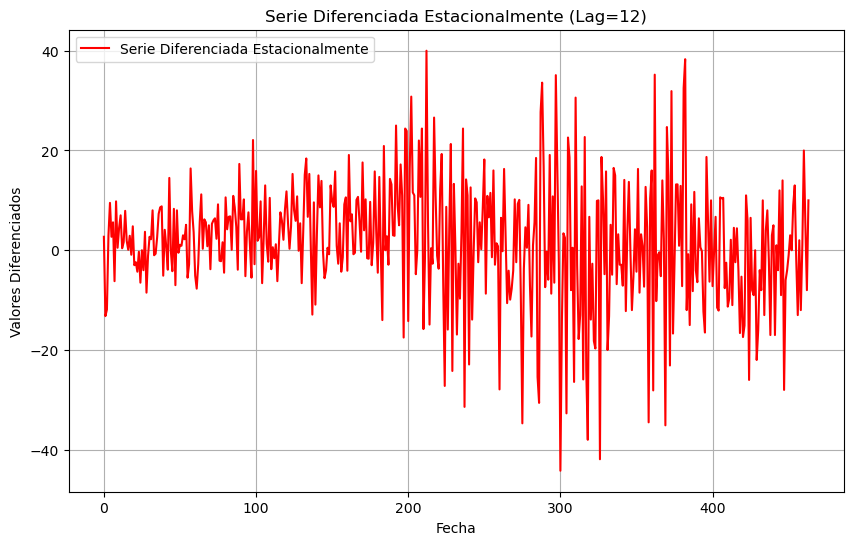

In [115]:
# Graficar la serie diferenciada estacionalmente
plt.figure(figsize=(10, 6))
plt.plot(datos_seasonal_diff, label="Serie Diferenciada Estacionalmente", color="red")
plt.title("Serie Diferenciada Estacionalmente (Lag=12)")
plt.xlabel("Fecha")
plt.ylabel("Valores Diferenciados")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

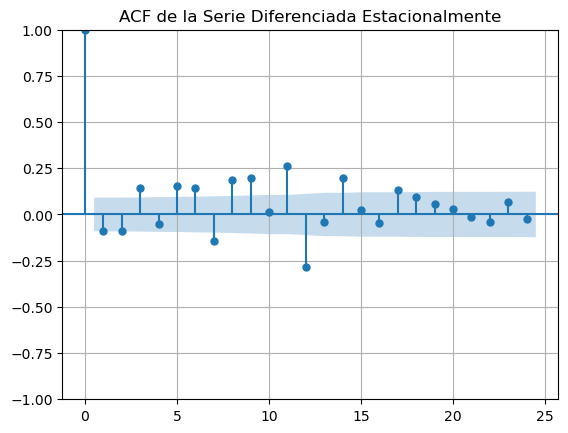

In [116]:
# Graficar ACF y PACF de la serie estacionalmente diferenciada
plt.figure(figsize=(10, 6))
plot_acf(datos_seasonal_diff, lags=24)
plt.title("ACF de la Serie Diferenciada Estacionalmente")
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

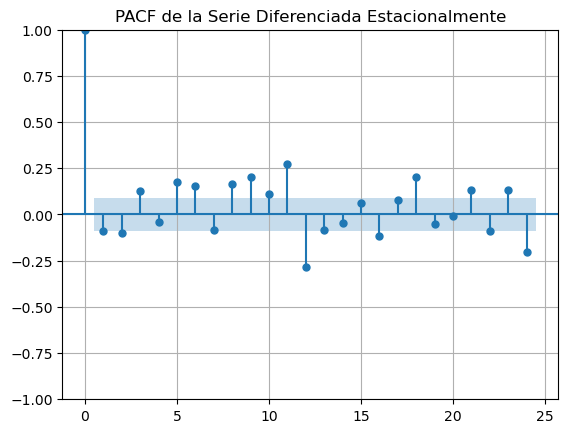

In [117]:
plt.figure(figsize=(10, 6))
plot_pacf(datos_seasonal_diff, lags=24)
plt.title("PACF de la Serie Diferenciada Estacionalmente")
plt.grid(True)
plt.show()

---
## **Paso 3: Determinar el modelo óptimo**
---
---

#### Para determinar el modelo, usaremos AutoARIMA de `pmdarima` para automatizar la selección de los parámetros. Luego, verificaremos el modelo seleccionado.

In [118]:
from pmdarima import auto_arima

# Ajustar el modelo AutoARIMA
modelo_autoarima = auto_arima(datos, 
                              seasonal=True, 
                              m=12,  # Frecuencia estacional (12 meses)
                              trace=True,  # Mostrar detalles
                              error_action='ignore', 
                              suppress_warnings=True, 
                              stepwise=True)  # Estrategia eficiente

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3556.022, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4180.337, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3905.859, Time=0.28 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3940.279, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4178.356, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=3897.413, Time=0.52 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=3555.128, Time=3.37 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=3645.528, Time=1.76 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.67 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=3555.093, Time=2.76 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=3810.481, Time=1.25 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=2.72 sec
 ARIMA(2,1,1)(1,0,2)[12] intercept   : AIC=3562.740, Time=2.42 sec
 ARIMA(3,1,2)(1,0,2)[12] intercept

In [119]:
print(modelo_autoarima.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  476
Model:             SARIMAX(2, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -1736.227
Date:                                 Fri, 20 Dec 2024   AIC                           3492.454
Time:                                         17:55:42   BIC                           3534.087
Sample:                                     01-01-1956   HQIC                          3508.826
                                          - 08-01-1995                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.013      0.039      0.969      -0.025       0

---
## **Paso 4: Comprobar el modelo estimado**
---
---

#### Para verificar el modelo:

1. Analizamos las predicciones y las comparamos con los datos reales.

2. Analizamos los residuos para comprobar que son ruido blanco (independientes y sin estructura).

In [120]:
# Dividir los datos en train (80%) y test (20%)
train_size = int(len(datos) * 0.8)
train, test = datos.iloc[:train_size], datos.iloc[train_size:]


In [121]:
# Ajustar el modelo con los datos de entrenamiento
modelo_autoarima.fit(train)

ARIMA(order=(2, 1, 3), scoring_args={}, seasonal_order=(1, 0, 2, 12),
      suppress_warnings=True)

In [122]:
# Predicciones en el conjunto de prueba
predicciones = modelo_autoarima.predict(n_periods=len(test))

In [123]:
# Convertir las predicciones a un DataFrame para graficar
predicciones = pd.DataFrame(predicciones, index=test.index, columns=['Predicciones'])

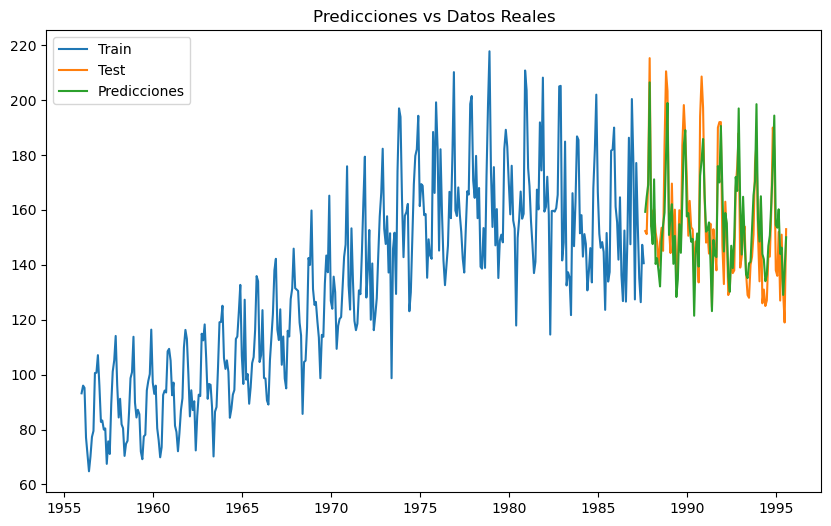

In [124]:
# Graficar las predicciones frente a los datos reales
plt.figure(figsize=(10, 6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(predicciones, label="Predicciones")
plt.title("Predicciones vs Datos Reales")
plt.legend()
plt.show()


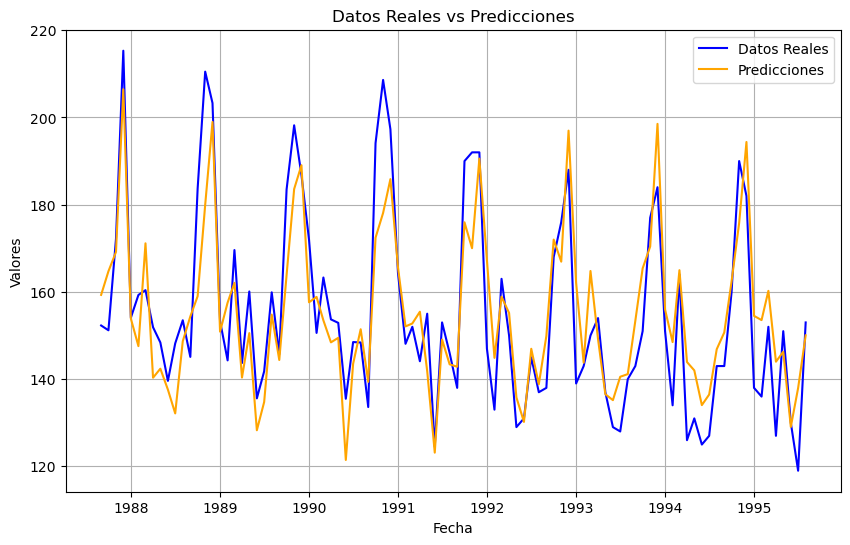

In [125]:
# Superponer los datos reales con las predicciones
plt.figure(figsize=(10, 6))

# Graficar los datos reales
plt.plot(test, label="Datos Reales", color="blue")

# Graficar las predicciones
plt.plot(predicciones, label="Predicciones", color="orange")

# Títulos y leyendas
plt.title("Datos Reales vs Predicciones")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.legend()
plt.grid(True)

plt.show()


In [126]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcular el MAE (Error Absoluto Medio)
mae = mean_absolute_error(test, predicciones)
print(f"Mean Absolute Error (MAE): {mae}")

# Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse = mean_squared_error(test, predicciones, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Coeficiente de Determinación R^2
from sklearn.metrics import r2_score
r2 = r2_score(test, predicciones)
print(f"R-squared (R2): {r2}")


Mean Absolute Error (MAE): 8.988848118926969
Root Mean Squared Error (RMSE): 11.241875192432763
R-squared (R2): 0.7362224209965729


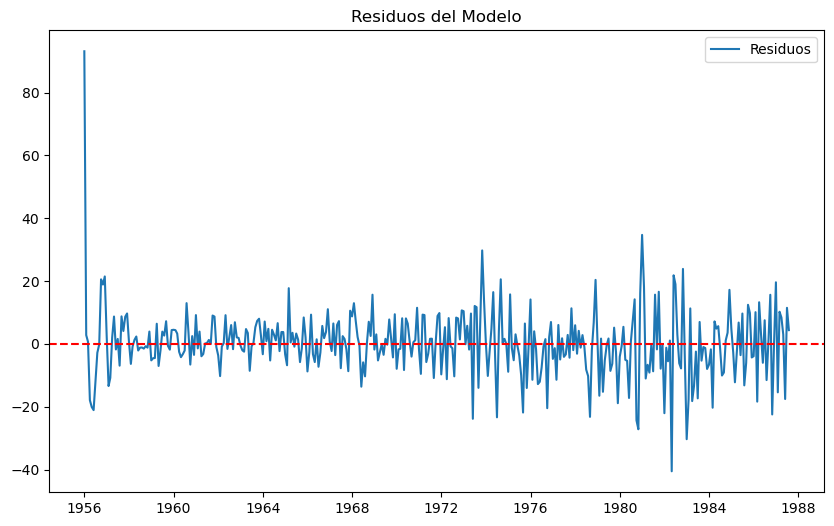

In [127]:
# Obtener residuos
residuos = modelo_autoarima.resid()

# Graficar residuos
plt.figure(figsize=(10, 6))
plt.plot(residuos, label="Residuos")
plt.axhline(0, linestyle='--', color='r')
plt.title("Residuos del Modelo")
plt.legend()
plt.show()


      lb_stat  lb_pvalue
10  20.358577   0.026038


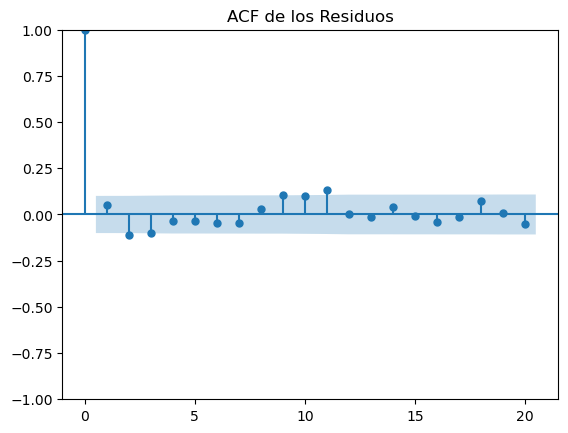

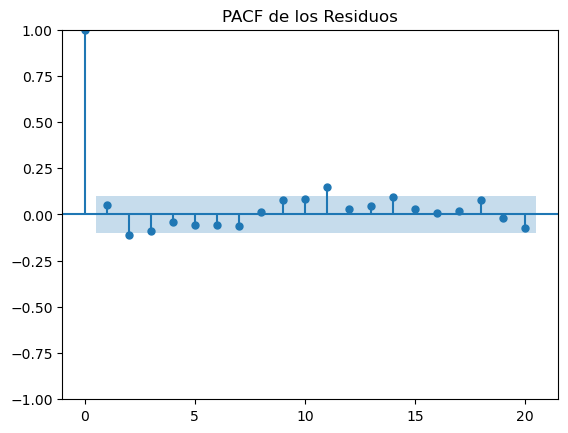

In [128]:
# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(ljung_box)

# Graficar ACF y PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(residuos, lags=20)
plt.title("ACF de los Residuos")
plt.show()

plot_pacf(residuos, lags=20)
plt.title("PACF de los Residuos")
plt.show()


In [129]:

# Test de ruido blanco en los residuos
from statsmodels.stats.diagnostic import acorr_ljungbox

# Prueba de Ljung-Box: H0 = Residuos son ruido blanco
ljung_box = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(ljung_box)

if ljung_box["lb_pvalue"].values[0] > 0.05:
    print("No rechazamos H0: Los residuos parecen ruido blanco")
else:
    print("Rechazamos H0: Los residuos NO son ruido blanco")


      lb_stat  lb_pvalue
10  20.358577   0.026038
Rechazamos H0: Los residuos NO son ruido blanco
